In [76]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt ;
import seaborn as sns;
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold , GridSearchCV

from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score, confusion_matrix, classification_report, roc_auc_score

# Import Data Set

In [78]:
train_data = pd.read_csv('train.csv');
test_data = pd.read_csv('test.csv');

train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# Exploratory Data Analysis & Data Pre-Processing

In [80]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [81]:
train_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [82]:
train_data.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [83]:
train_data['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

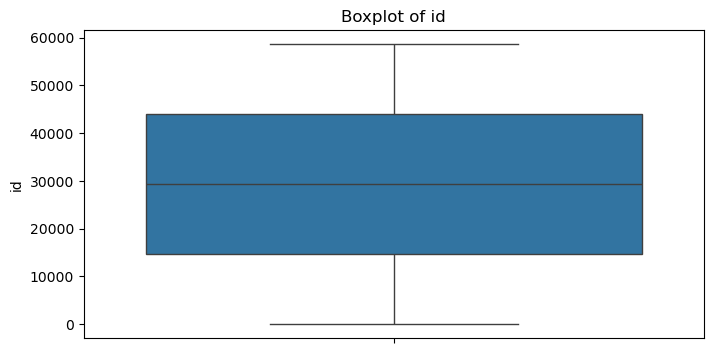

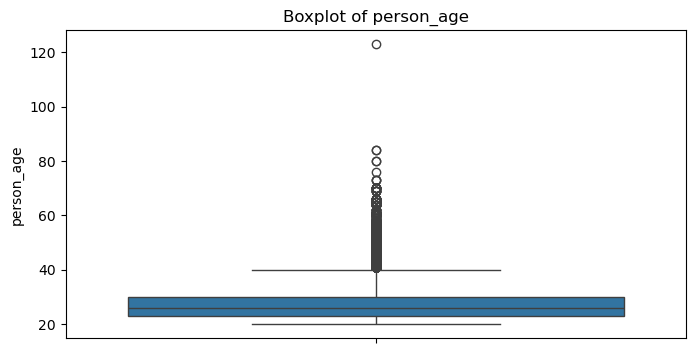

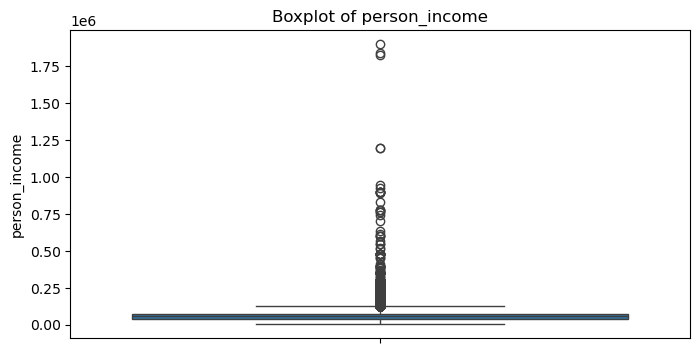

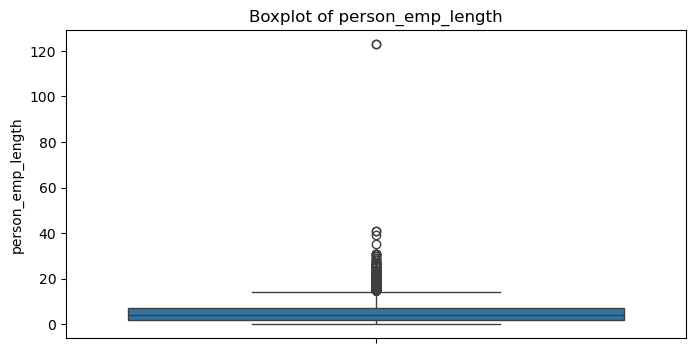

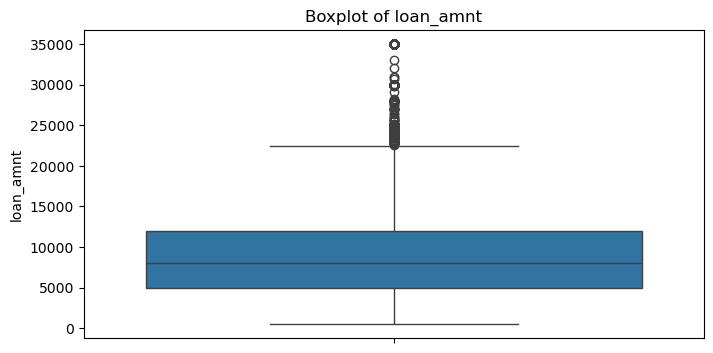

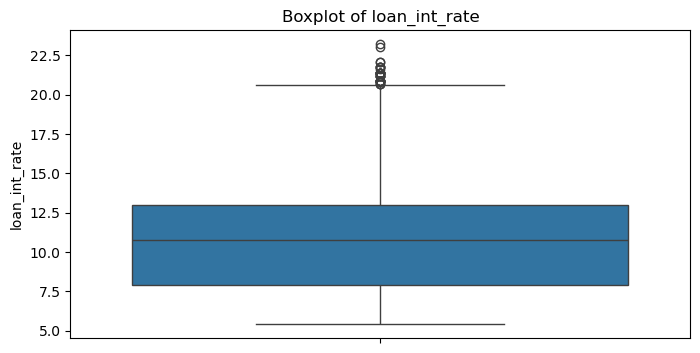

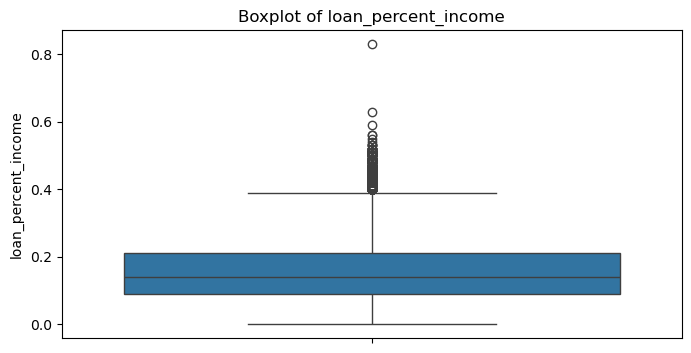

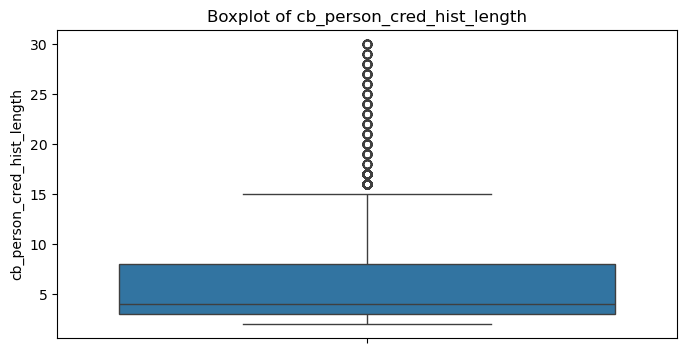

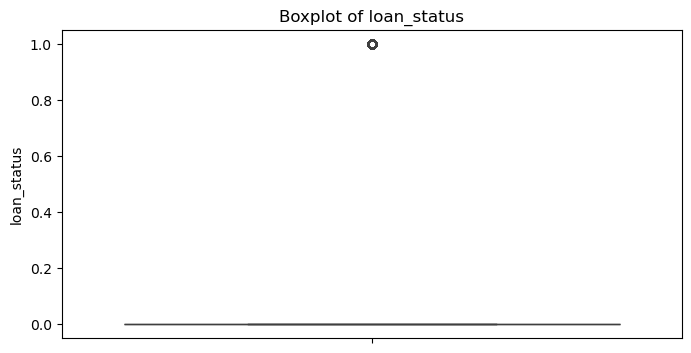

In [84]:
#checking the outliers:

numeric_columns = train_data.select_dtypes(include = ['float64','int64']).columns

for col in numeric_columns:
    plt.figure(figsize = (8,4))
    sns.boxplot(train_data[col])
    plt.title(f'Boxplot of {col}');
    plt.show()

In [85]:
# Columns like person_age,person_income, person_emp_length, loan_amnt, loan_int_rate, loan_pescent_income, cb_person_cred_hist_length has outliers

# IQR Method :

Q1 = train_data[numeric_columns].quantile(0.25)
Q3 = train_data[numeric_columns].quantile(0.75)

IQR = Q3-Q1

lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR

outliers_iqr = ((train_data[numeric_columns] < lower_bound) | (train_data[numeric_columns] > upper_bound))

outliers_iqr.sum()

id                               0
person_age                    2446
person_income                 2411
person_emp_length             1274
loan_amnt                     2045
loan_int_rate                   34
loan_percent_income           1210
cb_person_cred_hist_length    1993
loan_status                   8350
dtype: int64

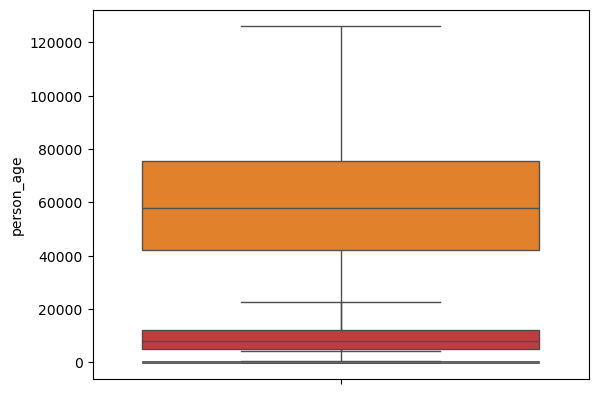

In [86]:
# Capping method to keep the outliers.

def cap_outliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df[column] = df[column].apply(lambda x: upper_bound if x > upper_bound else (lower_bound if x < lower_bound else x))

    return df[column]

columns_with_outliers = [ 'person_age','person_income','person_emp_length','loan_amnt','loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length'];

for col in columns_with_outliers:
    train_data[col] = cap_outliers(train_data,col)

sns.boxplot(data=train_data['person_age'])
sns.boxplot(data=train_data['person_income'])
sns.boxplot(data=train_data['person_emp_length'])
sns.boxplot(data=train_data['loan_amnt'])
sns.boxplot(data=train_data['loan_int_rate'])
sns.boxplot(data=train_data['loan_percent_income'])
sns.boxplot(data=train_data['cb_person_cred_hist_length'])

plt.show()

In [87]:
print(train_data.columns)

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'loan_status'],
      dtype='object')


In [88]:
def preprocess_data(train_data, test_data):  
 loan_grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    
# Apply the loan_grade mapping to both train and test sets

 train_data['loan_grade'] = train_data['loan_grade'].map(loan_grade_mapping)
 test_data['loan_grade'] = test_data['loan_grade'].map(loan_grade_mapping)
    
# OneHotEncoder for other categorical columns
 one_hot_enc = OneHotEncoder(drop='first', sparse_output=False, dtype=int)
    
# Categorical columns for OneHotEncoder
 one_hot_cols = ['person_home_ownership', 'cb_person_default_on_file', 'loan_intent']

# Fit the OneHotEncoder on the training data and transform both train and test
 one_hot_encoded_train = one_hot_enc.fit_transform(train_data[one_hot_cols])
 one_hot_encoded_test = one_hot_enc.transform(test_data[one_hot_cols])
    
# Convert the encoded arrays into DataFrames
 one_hot_encoded_train = pd.DataFrame(one_hot_encoded_train, columns=one_hot_enc.get_feature_names_out(one_hot_cols), index=train_data.index)
 one_hot_encoded_test = pd.DataFrame(one_hot_encoded_test, columns=one_hot_enc.get_feature_names_out(one_hot_cols), index=test_data.index)
    
# Drop original one-hot encoded columns from train and test data
 train_data = train_data.drop(columns=one_hot_cols)
 test_data = test_data.drop(columns=one_hot_cols)
    
# Concatenate the one-hot encoded columns back to the train and test data
 df_train_processed = pd.concat([train_data, one_hot_encoded_train], axis=1)
 df_test_processed = pd.concat([test_data, one_hot_encoded_test], axis=1)
    
# Ensure the test set has the same columns as the train set (excluding 'loan_status')
 train_columns = df_train_processed.drop(columns=['loan_status']).columns 
 df_test_processed = df_test_processed.reindex(columns=train_columns, fill_value=0)
    
 return df_train_processed, df_test_processed

df_train_processed, df_test_processed = preprocess_data(train_data,test_data)

In [89]:
    print(df_train_processed.columns)
    print(df_test_processed.columns)
    print("Processed train shape:", df_train_processed.shape)
    print("Processed test shape:", df_test_processed.shape)


Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'loan_status',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'cb_person_default_on_file_Y',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')
Index(['id', 'person_age', 'person_income', 'person_emp_length', 'loan_grade',
       'loan_amnt', 'loan_int_rate', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'cb_person_default_on_file_Y', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE'],
      dtype='object')
Processed train shape: (58645, 19)
Pr

In [90]:
df_train_processed.head()

,id,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,cb_person_default_on_file_Y,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE
0,0,37.0,35000.0,0.0,2,6000.0,11.49,0.17,14.0,0,0,0,1,0,1,0,0,0,0
1,1,22.0,56000.0,6.0,3,4000.0,13.35,0.07,2.0,0,0,1,0,0,0,0,1,0,0
2,2,29.0,28800.0,8.0,1,6000.0,8.90,0.21,10.0,0,0,1,0,0,0,0,0,1,0
3,3,30.0,70000.0,14.0,2,12000.0,11.11,0.17,5.0,0,0,0,1,0,0,0,0,0,1
4,4,22.0,60000.0,2.0,1,6000.0,6.92,0.10,3.0,0,0,0,1,0,0,0,1,0,0


# Building the Model:

In [101]:
X = df_train_processed.drop(columns = ['loan_status'], axis = 1)
y = df_train_processed['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, test_size = 0.3, stratify = y, shuffle = True)

In [103]:
cv_params = {'max_depth':[3,4,5,6,7,8],'min_child_weight':[1,2,3,4,5],'learning_rate':[0.1,0.2,0.3],'n_estimators':[75,100,125]}
xgb_model = XGBClassifier(objective = 'binary:logistic', random_state = 41)

In [105]:
# StratifiedK-fold with 3 splits and define scoring

stratified_K_fold = StratifiedKFold(n_splits = 5)
scoring = 'roc_auc'

xgb_cv = GridSearchCV(xgb_model, cv_params, scoring = scoring, cv = stratified_K_fold, refit = 'roc_auc')

xgb_cv.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=41, ...),
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [3, 4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='roc_auc', scoring='roc_auc')

In [107]:
best_xgb_model = xgb_cv.best_estimator_

y_pred = best_xgb_model.predict_proba(X_test)[:, 1]

In [109]:
auc_score = roc_auc_score(y_test, y_pred)

print("AUC Score:",auc_score)

AUC Score: 0.9558045682113142


In [111]:
y_pred = best_xgb_model.predict(X_test)

In [113]:
# Calculate Mettrics

f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print('f1 Score:', f1);
print('recall:', recall)
print('precision:', precision)
print('accuracy:', accuracy)

f1 Score: 0.8090238999329908
recall: 0.7229540918163673
precision: 0.9183569979716024
accuracy: 0.9514038876889849


# Submission:

In [116]:

df_sub = pd.read_csv('sample_submission.csv')

loan_status_pred = best_xgb_model.predict(df_test_processed)

df_sub['loan_status'] = loan_status_pred 
submission_file = 'submission.csv'
df_sub.to_csv(submission_file, index=False)

print(df_sub.head())


      id  loan_status
0  58645            1
1  58646            0
2  58647            1
3  58648            0
4  58649            0
